# Big Data Coursework - US Treasury Bond Return Prediction

## 1. Read Data

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import datetime
import yfinance as yf
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### 1.1 FRED Data

In [2]:
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2026, 1, 31)

fred_codes = [
    'DGS10',    # 10-year Treasury yield
    'T10Y2Y',   # Term spread
    'DGS5',     # 5-Year Treasury yield
    'DGS2',     # 2-Year Treasury yield
    'TB3MS',    # 3-Month Treasury rate
    'BAA',      # Moody's BAA Corporate Bond Yield
    'AAA',      # Moody's AAA Corporate Bond Yield
    'BAMLC0A0CMEY', # ICE BofA US Corporate Index Effective Yield
    'BAMLH0A0HYM2EY', # ICE BofA US High Yield Index Effective Yield
    'TEDRATE',  # TED Spread (3M LIBOR - 3M T-Bill)
    'CPIAUCSL', # Consumer Price Index
    'T10YIE',   # 10-Year Breakeven Inflation Rate
    'UNRATE',   # Unemployment Rate
    'INDPRO',   # Industrial Production Index
    'USREC',    # NBER Recession Indicator
    'VIXCLS',   # VIX Index (Equity Volatility)
]

df_fred = pdr.DataReader(fred_codes, 'fred', start, end)

In [11]:
df_fred.head()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS
DATE,,,,,,,,,,,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,7.64,9.94,8.99,NaN,NaN,NaN,127.5,NaN,5.4,61.729,0.0,NaN
1990-01-02,7.94,0.07,7.87,7.87,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,17.24
1990-01-03,7.99,0.05,7.92,7.94,NaN,NaN,NaN,NaN,NaN,0.75,NaN,NaN,NaN,NaN,NaN,18.19
1990-01-04,7.98,0.06,7.91,7.92,NaN,NaN,NaN,NaN,NaN,0.79,NaN,NaN,NaN,NaN,NaN,19.22
1990-01-05,7.99,0.09,7.92,7.90,NaN,NaN,NaN,NaN,NaN,0.84,NaN,NaN,NaN,NaN,NaN,20.11


In [12]:
# resample to monthly frequency (using end-of-month values)
df_fred_monthly = df_fred.resample('MS').last()

df_fred_monthly.head()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS
DATE,,,,,,,,,,,,,,,,
1990-01-01,8.43,0.15,8.35,8.28,7.64,9.94,8.99,NaN,NaN,0.63,127.5,NaN,5.4,61.7290,0.0,25.36
1990-02-01,8.51,0.08,8.44,8.43,7.74,10.14,9.22,NaN,NaN,0.61,128.0,NaN,5.3,62.2896,0.0,21.99
1990-03-01,8.65,0.01,8.65,8.64,7.90,10.21,9.37,NaN,NaN,0.70,128.6,NaN,5.2,62.5999,0.0,19.73
1990-04-01,9.04,0.08,9.04,8.96,7.77,10.30,9.46,NaN,NaN,0.90,128.9,NaN,5.4,62.4359,0.0,19.52
1990-05-01,8.60,0.10,8.56,8.50,7.74,10.41,9.47,NaN,NaN,0.62,129.1,NaN,5.4,62.6258,0.0,17.37


In [13]:
df_fred_monthly.tail()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS
DATE,,,,,,,,,,,,,,,,
2025-09-01,4.16,0.56,3.74,3.60,3.92,5.83,5.21,4.83,6.56,NaN,324.245,2.36,4.4,101.7779,0.0,16.28
2025-10-01,4.11,0.51,3.71,3.60,3.82,5.74,5.13,4.82,6.67,NaN,NaN,2.30,NaN,101.5163,0.0,17.44
2025-11-01,4.02,0.55,3.59,3.47,3.78,5.86,5.26,4.78,6.56,NaN,325.063,2.23,4.5,101.9528,0.0,16.35
2025-12-01,4.18,0.71,3.73,3.47,3.59,5.90,5.31,4.84,6.53,NaN,326.031,2.25,4.4,102.3250,0.0,14.95
2026-01-01,4.26,0.74,3.79,3.52,3.57,5.88,5.34,4.85,6.66,NaN,326.588,2.36,4.3,NaN,0.0,17.44


### 1.2 Yahoo Finance Data

In [14]:
# MOVE Index
df_move = yf.download("^MOVE", start="1990-01-01", end="2026-01-31")

[*********************100%***********************]  1 of 1 completed


In [15]:
df_move.head()

Price,Close,High,Low,Open,Volume
Ticker,^MOVE,^MOVE,^MOVE,^MOVE,^MOVE
Date,,,,,
2002-11-12,120.209999,120.209999,120.209999,120.209999,0
2002-11-13,122.879997,122.879997,122.879997,122.879997,0
2002-11-14,130.289993,130.289993,130.289993,130.289993,0
2002-11-15,132.350006,132.350006,132.350006,132.350006,0
2002-11-18,129.139999,129.139999,129.139999,129.139999,0


In [16]:
# resample to monthly to match FRED data
df_move_monthly = df_move['Close'].resample('MS').last()
df_move_monthly.head()

Ticker,^MOVE
Date,
2002-11-01,127.519997
2002-12-01,123.889999
2003-01-01,110.889999
2003-02-01,105.360001
2003-03-01,112.089996


### 1.3 Combine Data

In [17]:
df = df_fred_monthly.merge(df_move_monthly, left_on="DATE", right_on="Date", how="outer").set_index(df_fred_monthly.index)

df.head()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS,^MOVE
DATE,,,,,,,,,,,,,,,,,
1990-01-01,8.43,0.15,8.35,8.28,7.64,9.94,8.99,NaN,NaN,0.63,127.5,NaN,5.4,61.7290,0.0,25.36,NaN
1990-02-01,8.51,0.08,8.44,8.43,7.74,10.14,9.22,NaN,NaN,0.61,128.0,NaN,5.3,62.2896,0.0,21.99,NaN
1990-03-01,8.65,0.01,8.65,8.64,7.90,10.21,9.37,NaN,NaN,0.70,128.6,NaN,5.2,62.5999,0.0,19.73,NaN
1990-04-01,9.04,0.08,9.04,8.96,7.77,10.30,9.46,NaN,NaN,0.90,128.9,NaN,5.4,62.4359,0.0,19.52,NaN
1990-05-01,8.60,0.10,8.56,8.50,7.74,10.41,9.47,NaN,NaN,0.62,129.1,NaN,5.4,62.6258,0.0,17.37,NaN


In [18]:
df.tail()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS,^MOVE
DATE,,,,,,,,,,,,,,,,,
2025-09-01,4.16,0.56,3.74,3.60,3.92,5.83,5.21,4.83,6.56,NaN,324.245,2.36,4.4,101.7779,0.0,16.28,77.930000
2025-10-01,4.11,0.51,3.71,3.60,3.82,5.74,5.13,4.82,6.67,NaN,NaN,2.30,NaN,101.5163,0.0,17.44,66.610001
2025-11-01,4.02,0.55,3.59,3.47,3.78,5.86,5.26,4.78,6.56,NaN,325.063,2.23,4.5,101.9528,0.0,16.35,68.949997
2025-12-01,4.18,0.71,3.73,3.47,3.59,5.90,5.31,4.84,6.53,NaN,326.031,2.25,4.4,102.3250,0.0,14.95,63.959999
2026-01-01,4.26,0.74,3.79,3.52,3.57,5.88,5.34,4.85,6.66,NaN,326.588,2.36,4.3,NaN,0.0,17.44,59.200001


## 2. EDA & Data Preprocessing

### 2.1 Check Data Size, Type, Missing Value

In [19]:
print(df_fred_monthly.shape)
print(df_move_monthly.shape)
print(df.shape)

(433, 16)
(279, 1)
(433, 17)


In [20]:
df_fred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9637 entries, 1990-01-01 to 2026-01-31
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           9025 non-null   float64
 1   T10Y2Y          9025 non-null   float64
 2   DGS5            9025 non-null   float64
 3   DGS2            9025 non-null   float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    7593 non-null   float64
 8   BAMLH0A0HYM2EY  7594 non-null   float64
 9   TEDRATE         7869 non-null   float64
 10  CPIAUCSL        432 non-null    float64
 11  T10YIE          5773 non-null   float64
 12  UNRATE          432 non-null    float64
 13  INDPRO          432 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          9113 non-null   float64
dtypes: float64(16)
memory usage: 1.2 MB


In [21]:
df_fred_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           433 non-null    float64
 1   T10Y2Y          433 non-null    float64
 2   DGS5            433 non-null    float64
 3   DGS2            433 non-null    float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    350 non-null    float64
 8   BAMLH0A0HYM2EY  350 non-null    float64
 9   TEDRATE         385 non-null    float64
 10  CPIAUCSL        432 non-null    float64
 11  T10YIE          277 non-null    float64
 12  UNRATE          432 non-null    float64
 13  INDPRO          432 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          433 non-null    float64
dtypes: float64(16)
memory usage: 57.5 KB


In [22]:
df_move.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5739 entries, 2002-11-12 to 2026-01-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^MOVE)   5739 non-null   float64
 1   (High, ^MOVE)    5739 non-null   float64
 2   (Low, ^MOVE)     5739 non-null   float64
 3   (Open, ^MOVE)    5739 non-null   float64
 4   (Volume, ^MOVE)  5739 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 269.0 KB


In [23]:
df_move_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 279 entries, 2002-11-01 to 2026-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^MOVE   279 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           433 non-null    float64
 1   T10Y2Y          433 non-null    float64
 2   DGS5            433 non-null    float64
 3   DGS2            433 non-null    float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    350 non-null    float64
 8   BAMLH0A0HYM2EY  350 non-null    float64
 9   TEDRATE         385 non-null    float64
 10  CPIAUCSL        432 non-null    float64
 11  T10YIE          277 non-null    float64
 12  UNRATE          432 non-null    float64
 13  INDPRO          432 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          433 non-null    float64
 16  ^MOVE           279 non-null    float64
dtypes: floa

In [27]:
df.describe()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS,^MOVE
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,350.000000,350.000000,385.000000,432.000000,277.000000,432.000000,432.000000,433.000000,433.000000,279.000000
mean,4.233164,1.004596,3.743949,3.228568,2.714388,6.541224,5.603557,4.790057,8.418857,0.466494,210.264569,2.104296,5.674074,90.331354,0.083141,19.490115,87.115627
std,1.942603,0.913134,2.110034,2.267491,2.206836,1.734343,1.748652,1.598557,2.752965,0.356484,51.769583,0.397182,1.740956,12.887392,0.276414,7.409734,30.774559
min,0.550000,-1.060000,0.210000,0.110000,0.010000,3.160000,2.140000,1.790000,4.010000,0.060000,127.500000,0.110000,3.400000,60.334600,0.000000,9.510000,39.209999
25%,2.600000,0.240000,1.810000,0.940000,0.260000,5.190000,4.070000,3.380000,6.545000,0.230000,164.625000,1.840000,4.400000,85.953900,0.000000,13.830000,63.680000
50%,4.140000,0.910000,3.720000,3.290000,2.640000,6.320000,5.400000,4.825000,7.845000,0.380000,211.421500,2.220000,5.400000,94.751600,0.000000,17.470000,80.080002
75%,5.680000,1.820000,5.370000,4.970000,4.870000,7.950000,7.080000,5.987500,9.395000,0.570000,242.882250,2.370000,6.600000,100.267425,0.000000,23.380000,105.135002
max,9.040000,2.840000,9.040000,8.960000,7.900000,10.740000,9.560000,9.230000,21.810000,3.150000,326.588000,2.880000,14.800000,104.100400,1.000000,59.890000,214.000000


As seen, the column `DGS10` in  has many missing value. The reason behiind this is usually holidays (e.g., bank holiday). As later showed that we use the daily data for bond volatility calculation, we need to handle this missing value.

### 2.2 Base Data Cleaning and Feature Engineering

Fill the null value of fred `DGS10` using forward fill to avoid look-ahead-bias.

In [28]:
df_fred['DGS10_filled'] = df_fred['DGS10'].ffill()

Now we construct the target variable: `Monthly excess return on 10Y Treasury`.

Remember that yield != return. Yield is what we would earn if we held the bond for 10 years and interest rates never changed.

In [29]:
duration = 9  # standard approximation for a 10-Year Bond

# 1. price change (capital gain/loss due to change in yield). divide by 100 to convert to decimal
df['price_ret'] = -duration * (df['DGS10'].diff() / 100)

# 2. carry (the interest earned during the month): use the yield from the START of the month (shift 1)
df['carry_ret'] = (df['DGS10'].shift(1) / 100) / 12

# 3. excess return = total bond return minus the risk-free rate (TB3MS)
df['total_bond_ret'] = df['price_ret'] + df['carry_ret']
df['excess_return'] = df['total_bond_ret'] - ((df['TB3MS'] / 100) / 12)

The following features have missing values, so we need to handle them:

|no| variable name   |non-null count| dtype |
|--|-----------------|--------------|-------|
| 7 |  BAMLC0A0CMEY   | 350 non-null |float64|
| 8 |  BAMLH0A0HYM2EY | 350 non-null |float64|
| 9 |  TEDRATE        | 385 non-null |float64|
| 10 | CPIAUCSL       | 431 non-null |float64|
| 11 | T10YIE         | 277 non-null |float64|
| 12 | UNRATE         | 431 non-null |float64|
| 13 | INDPRO         | 432 non-null |float64|
| 16 | ^MOVE          | 279 non-null |float64|

Notes:
- `BAMLC0A0CMEY` and `BAMLH0A0HYM2EY` are entirely not used as the missing value is ~20%, and cutting all the missing value will make us lose many data --> So we will not use **Credit spread (IG)** and **Credit spread (HY)** as predictors.
- The same for `T10YIE`, that will cause us to lose almost ~40% of our data --> So we will not use **Breakeven inflation** as predictor.
- `TEDRATE` is discontinued as of January 31, 2022 --> So we will not use **TED spread** at this point. Might find an alternative of this (e.g., SOFR-based spreads), or the Default spread is already enough to measure Credit
- `^MOVE` is only available from 2002 onwards, and if we cut the row that does not have this value, we will lose almost ~40%. MOVE measures **implied volatiliy** in the U.S. Treasury bond market, based on options on Treasury futures across 2, 5, 10, and 30-year maturities to gauge market sentiment regarding interest rate risk. Therefore, on time prior to this measure is available, we can use the the **realized volatility** as an alternative (backfilling).

In [30]:
# fill minor missing macro values
df[['CPIAUCSL', 'UNRATE', 'INDPRO']] = df[['CPIAUCSL', 'UNRATE', 'INDPRO']].ffill()

# construct predictors (from project data source excel)
df['slope'] = df['T10Y2Y']
df['curvature'] = (2 * df['DGS5']) - df['DGS2'] - df['DGS10']
df['short_rate'] = df['TB3MS']
df['default_spread'] = df['BAA'] - df['AAA']
# df['credit_spread_ig] = ...
# df['credit_spread_hy] = ...
# df['ted_spread'] = ...
df['inflation_yoy'] = df['CPIAUCSL'].pct_change(periods=12)
df['unemployment'] = df['UNRATE']
df['recession_indicator'] = df['USREC']
df['industrial_prod_yoy'] = df['INDPRO'].pct_change(periods=12)
df['vix_index'] = df['VIXCLS']

# construct realized vol from DGS10 to fill the gap before 2002
# the volatility is calculated from the daily data, not the monthly data (we use higher frequency data)
# because volatility might occur in the middle of month, which cannot be captured if we only use start of month (monthly basis)
df_fred['yield_diff'] = df_fred['DGS10_filled'].diff()
# annualized vol. and rolling is by default "left-aligned"/"backward direction", so we avoid look-ahead-bias here
df_fred['realized_daily_vol_30d'] = df_fred['yield_diff'].rolling(window=30).std() * np.sqrt(252)
# use .last() so we use the volatility known at the end of the month
df['realized_bond_vol_30d'] = df_fred['realized_daily_vol_30d'].resample('MS').last() * 100
df['bond_volatility'] = df['^MOVE'].fillna(df['realized_bond_vol_30d'])

# past 12-month bond return
df['excess_return_12m'] = df['excess_return'].rolling(window=12).sum()
df['bond_momentum'] = df['excess_return_12m'].shift(1) # lag by 1 month

Finalize the data to be used forward.

In [31]:
predictors = ['slope', 'curvature', 'short_rate', 'default_spread', 'inflation_yoy', 'unemployment',
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

# lagging predictors. avoid look-ahead bias!
# we must use T-1 data to predict T returns
X = df[predictors].shift(1) # lag features by one month
y = df['excess_return']

X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   slope                432 non-null    float64
 1   curvature            432 non-null    float64
 2   short_rate           432 non-null    float64
 3   default_spread       432 non-null    float64
 4   inflation_yoy        420 non-null    float64
 5   unemployment         432 non-null    float64
 6   recession_indicator  432 non-null    float64
 7   industrial_prod_yoy  420 non-null    float64
 8   vix_index            432 non-null    float64
 9   bond_volatility      431 non-null    float64
 10  bond_momentum        419 non-null    float64
dtypes: float64(11)
memory usage: 40.6 KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Series name: excess_return
Non-Null Count  Dtype  
--------------  -----  
43

In [32]:
# combine and drop NaN due to shift/pct_change
df_final = pd.concat([y, X], axis=1).dropna()

print(f"Final dataset prepared from {df_final.index.min()} to {df_final.index.max()}")
df_final.head()

Final dataset prepared from 1991-03-01 00:00:00 to 2026-01-01 00:00:00


,excess_return,slope,curvature,short_rate,default_spread,inflation_yoy,unemployment,recession_indicator,industrial_prod_yoy,vix_index,bond_volatility,bond_momentum
DATE,,,,,,,,,,,,
1991-03-01,-0.000942,0.98,0.26,5.94,1.24,0.053125,6.6,1.0,-0.025780,21.23,61.034868,0.047825
1991-04-01,0.004700,1.03,0.39,5.91,1.16,0.048212,6.8,1.0,-0.036187,16.88,73.559828,0.057092
1991-05-01,-0.001467,1.22,0.44,5.65,1.08,0.048099,6.7,0.0,-0.031106,18.24,68.587824,0.068242
1991-06-01,-0.014125,1.38,0.64,5.46,1.00,0.050349,6.9,0.0,-0.024950,15.93,62.634572,0.107308
1991-07-01,0.005817,1.34,0.66,5.57,0.95,0.046959,6.9,0.0,-0.020371,19.55,57.423292,0.065158


In [33]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419 entries, 1991-03-01 to 2026-01-01
Freq: MS
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   excess_return        419 non-null    float64
 1   slope                419 non-null    float64
 2   curvature            419 non-null    float64
 3   short_rate           419 non-null    float64
 4   default_spread       419 non-null    float64
 5   inflation_yoy        419 non-null    float64
 6   unemployment         419 non-null    float64
 7   recession_indicator  419 non-null    float64
 8   industrial_prod_yoy  419 non-null    float64
 9   vix_index            419 non-null    float64
 10  bond_volatility      419 non-null    float64
 11  bond_momentum        419 non-null    float64
dtypes: float64(12)
memory usage: 42.6 KB


### 2.3 Stationarity

We need to check if our variables are stationary or not.

This is important for time-series regression, as non-stationary target or predictors will give us spurious regression.

In [34]:
def run_stationarity_test(df):
    results = []
    for col in df.columns:
        # perform Augmented Dickey-Fuller test
        adf_result = adfuller(df[col].dropna())

        # extract values
        results.append({
            'Variable': col,
            'ADF Statistic': round(adf_result[0], 4),
            'p-value': round(adf_result[1], 4),
            'Stationary (5%)': 'Yes' if adf_result[1] < 0.05 else 'No'
        })

    return pd.DataFrame(results)

In [35]:
stationarity_table = run_stationarity_test(df_final)
stationarity_table

,Variable,ADF Statistic,p-value,Stationary (5%)
0,excess_return,-14.9870,0.0000,Yes
1,slope,-3.3006,0.0149,Yes
2,curvature,-3.5267,0.0073,Yes
3,short_rate,-2.7120,0.0720,No
4,default_spread,-4.6072,0.0001,Yes
5,inflation_yoy,-3.6499,0.0049,Yes
6,unemployment,-3.0127,0.0337,Yes
7,recession_indicator,-4.5488,0.0002,Yes
8,industrial_prod_yoy,-3.4636,0.0090,Yes
9,vix_index,-3.6461,0.0049,Yes


In [36]:
# visualize the target variable to check for volatility clusters or trends
fig = px.line(df_final, y='excess_return',
                     title='U.S. 10Y Treasury Monthly Excess Returns (Target Variable)',
                     labels={'index': 'Date', 'excess_return': 'Excess Return (Decimal)'},
                     template='plotly_white', height=500, width=1100,)
fig.show()

In [37]:
predictors = ['slope', 'curvature', 'short_rate', 'default_spread', 'inflation_yoy', 'unemployment',
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

df_long = df_final[predictors].reset_index().melt(
    id_vars='DATE',
    value_vars=predictors,
    var_name='Predictor',
    value_name='Value'
)

fig = px.line(
    df_long,
    x='DATE',
    y='Value',
    facet_col='Predictor',
    facet_col_wrap=3,
    facet_col_spacing=0.04,
    height=1000,
    width=1100,
    title='Exploratory Data Analysis: Predictors',
    template='plotly_white'
)

fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show()

We found that the `short_rate` is non-stationary. Thus we need to make it stationary by taking the first difference.

In [38]:
# make short-rate stationary: create the first difference for the short rate
df_final['short_rate_diff'] = df_final['short_rate'].diff()
df_final.dropna(inplace=True) # do not forget to dropna, as diff will make the first row null

In [39]:
stationarity_table = run_stationarity_test(df_final)
stationarity_table

,Variable,ADF Statistic,p-value,Stationary (5%)
0,excess_return,-14.9696,0.0000,Yes
1,slope,-2.9467,0.0402,Yes
2,curvature,-3.5987,0.0058,Yes
3,short_rate,-2.7046,0.0733,No
4,default_spread,-4.6117,0.0001,Yes
5,inflation_yoy,-3.6354,0.0051,Yes
6,unemployment,-3.0227,0.0328,Yes
7,recession_indicator,-4.5599,0.0002,Yes
8,industrial_prod_yoy,-3.4672,0.0089,Yes
9,vix_index,-3.6423,0.0050,Yes


In [40]:
# re-run ADF test
predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment',
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

df_long = df_final[predictors].reset_index().melt(
    id_vars='DATE',
    value_vars=predictors,
    var_name='Predictor',
    value_name='Value'
)

fig = px.line(
    df_long,
    x='DATE',
    y='Value',
    facet_col='Predictor',
    facet_col_wrap=3,
    facet_col_spacing=0.04,
    height=1000,
    width=1100,
    title='Exploratory Data Analysis: Predictors',
    template='plotly_white'
)

fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show()

### 2.4 Outlier Identification

In [41]:
from scipy.stats import zscore

# Z-scores for each variable
z_scores = np.abs(zscore(df_final))
outliers = (z_scores > 3)

# Identifying outliers
df_outliers = df_final[outliers.any(axis=1)]

Whether you need to remove outliers depends on the goal of your analysis and the characteristics of your data.

*   Remove outliers: When using linear regression (e.g., OLS), outliers can seriously affect the regression coefficients and the fit of the model.
*   Keep outliers: When these outliers reflect real market fluctuations or extreme events (e.g., financial crises, etc.) and robust regression or nonlinear models (e.g., Random Forest, XGBoost) are used, the model is usually more tolerant of outliers.

### 2.5 Statistical Summary of Variables

In [42]:
# Statistical summary
df_final.describe()

,excess_return,slope,curvature,short_rate,default_spread,inflation_yoy,unemployment,recession_indicator,industrial_prod_yoy,vix_index,bond_volatility,bond_momentum,short_rate_diff
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.002097,1.021770,0.025502,2.559043,0.934019,0.026101,5.672010,0.069378,0.015027,19.381507,87.046001,0.026577,-0.005622
std,0.023590,0.922162,0.293590,2.074733,0.369487,0.015362,1.767725,0.254400,0.041999,7.470776,28.292342,0.082606,0.187748
min,-0.083300,-1.060000,-0.650000,0.010000,0.550000,-0.019588,3.400000,0.000000,-0.173183,9.510000,31.294155,-0.218800,-1.230000
25%,-0.012015,0.250000,-0.160000,0.195000,0.692500,0.017153,4.300000,0.000000,-0.002724,13.752500,66.657501,-0.033681,-0.040000
50%,0.001950,0.945000,0.025000,2.360000,0.870000,0.025875,5.300000,0.000000,0.022936,17.285000,83.810679,0.033933,0.000000
75%,0.016263,1.850000,0.230000,4.712500,1.050000,0.031538,6.675000,0.000000,0.037698,23.342500,101.434358,0.086644,0.070000
max,0.100383,2.840000,0.820000,6.170000,3.380000,0.089794,14.800000,1.000000,0.165521,59.890000,214.000000,0.215275,0.740000


Excess return: std = 0.0236 indicates that the volatility of returns is relatively high, suggesting that excess returns have considerable fluctuations, possibly reflecting market uncertainty.

Macroeconomic Indicators: Variables such as interest rates, credit spreads, inflation, and unemployment exhibit fluctuations across different economic cycles, influencing bond and stock returns.

Volatility Indicators: The mean of bond_volatility is 87.05, which, compared to the VIX, shows that the bond market may be relatively more volatile, especially during times of increased economic uncertainty.

Recession Indicator (recession_indicator): The mean is 0.0694, indicating that the economy is in an expansion phase most of the time, with only about 6.94% of the time in recession.

### 2.6 Correlation and Bivariate Analysis

Check the correlation between variables.

In [43]:
all_cols = ['excess_return'] + ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment',
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

corr_matrix = df_final[all_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
df_corr_masked = corr_matrix.mask(mask)

fig_heatmap = px.imshow(
    df_corr_masked,
    text_auto=".2f",
    aspect="auto",
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1,
    title="Correlation Matrix: US 10Y Treasury Returns & Predictors",
    labels=dict(color="Correlation"),
    height=600,
    width=1100, template='plotly_white'
)
fig_heatmap.show()

In [44]:
target_corr = corr_matrix['excess_return'].drop('excess_return').sort_values(ascending=False)

fig_bar = px.bar(
    target_corr,
    orientation='h',
    text_auto=".2f",
    title="Predictor Correlation with Excess Returns",
    labels={'value': 'Correlation Coefficient', 'index': 'Predictor'},
    color=target_corr,
    color_continuous_scale='RdBu_r',
    range_color=[-0.5, 0.5], template='plotly_white'
)
fig_bar.show()

- Some predictors are really highly correlated. For example, `unemployment` and `slope` has a correlation coef of 0.71, and `default_spread` and `industrial_prod_yoy` has a correlation coef of -0.65.
- There is no predictor that has strong correlation with the target variable.

In [45]:
df_bivariate = df_final.melt(
    id_vars=['excess_return'],
    value_vars=predictors,
    var_name='Predictor',
    value_name='Value'
)

fig = px.scatter(
    df_bivariate,
    x='Value',
    y='excess_return',
    facet_col='Predictor',
    facet_col_wrap=3,           # 3 columns for better visibility
    trendline="ols",            # Adds a linear regression line to each plot
    trendline_color_override="red",
    height=1200,
    title="Bivariate Analysis: Predictors vs. Monthly Excess Return",
    labels={'Value': 'Predictor Value', 'excess_return': 'Excess Return'},
    template='plotly_white',
    opacity=0.5                 # Lower opacity helps see density of points
)

# independent x-axis: because units vary (e.g., VIX is ~20, slope is ~1.5)
fig.update_xaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show()

From the scatter plot we can see that the data points are widely scattered from the red line, we can say the predictor is noisy.
The signal-to-noise ratio is very low shown by:
- high dipersion
- shallow trendline (nearly horizontal)

In [46]:
window = 36  # 3-year rolling window

# calculate rolling correlations for all predictors
rolling_corr_list = []
for pred in predictors:
    # corr between target and current predictor
    series = df_final['excess_return'].rolling(window=window).corr(df_final[pred])
    temp_df = series.to_frame(name='Correlation')
    temp_df['Predictor'] = pred
    rolling_corr_list.append(temp_df)

df_rolling = pd.concat(rolling_corr_list).reset_index()

fig = px.line(
    df_rolling,
    x='DATE',
    y='Correlation',
    facet_col='Predictor',
    facet_col_wrap=3,
    height=1200,
    title=f"{window}-Month Rolling Correlation: Predictors vs. Excess Return",
    template='plotly_white'
)

fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(showlegend=False)

fig.show()

We use 36-month rolling window for the correaltion so that it is still responsive to economy shift, but still stable (too short window will cause us to catch termporary market noise rather than true structural change). Moreover, cycles usually last several years.

From the plot we can see that the correlations between the target variable and the predictors change over time. Typically, this will cause a simple OLS to fail to capture the complexity (because OLS assumes constant linear relationship). This also align with our previous claim that the signal-to-noise ratio is low, such that the trend/signal of the predictor relative to the target variable is not persistent. ==> **can be our justification for moving toward more flexible models like Random Forest and XGBOOST**

`recession_indicator` is a boolean (true/false) indicator, not a numerical feature.

In [27]:
# recession check
fig_box = px.box(
    df_final, x='recession_indicator', y='excess_return',
    color='recession_indicator',
    title="Excess Returns: Expansion vs Recession Regimes",
    points="all",
    template='plotly_white'
)
fig_box.show()

### 2.7 Autocorrelation (ACF/PACF)

a. Excess Return (Target Variable)

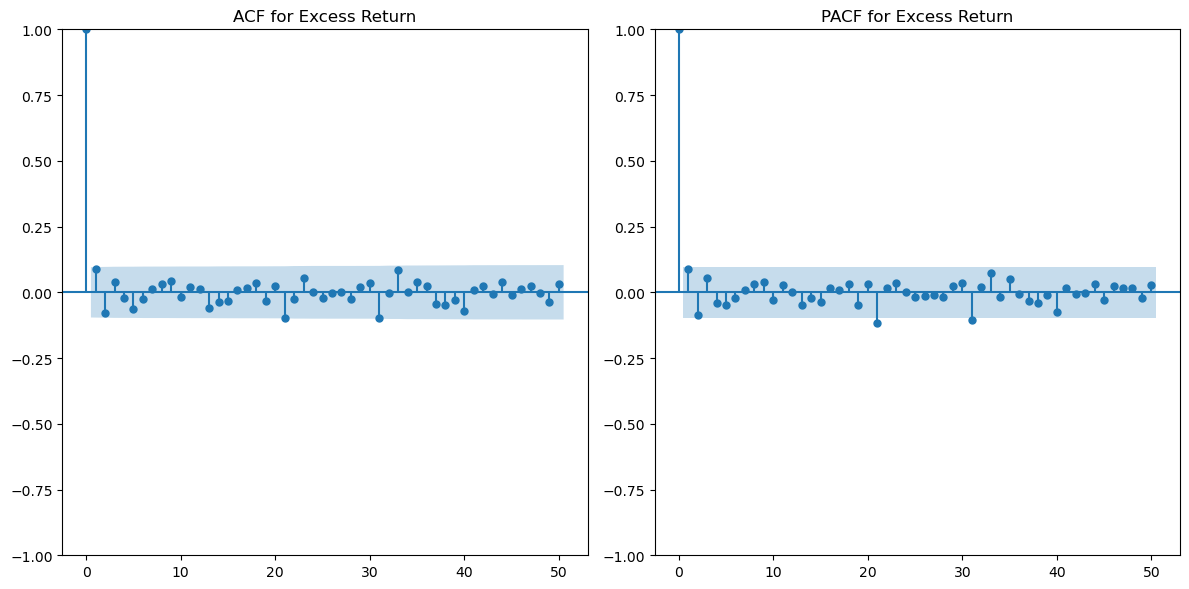

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF/PACF Excess Return
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_final['excess_return'].dropna(), ax=plt.gca(), lags=50)
plt.title('ACF for Excess Return')

plt.subplot(1, 2, 2)
plot_pacf(df_final['excess_return'].dropna(), ax=plt.gca(), lags=50)
plt.title('PACF for Excess Return')

plt.tight_layout()
plt.show()

The target variable lag 1 is at the "borderline" of the threshold. So, we take that lag 1 value as predictor in hope that it will give some predictive power even if it is small.

In [29]:
df_final['excess_return_lag1'] = df_final['excess_return'].shift(1)
df_final.dropna(inplace=True)

df_final.head()

,excess_return,slope,curvature,short_rate,default_spread,inflation_yoy,unemployment,recession_indicator,industrial_prod_yoy,vix_index,bond_volatility,bond_momentum,short_rate_diff,excess_return_lag1
DATE,,,,,,,,,,,,,,
1991-05-01,-0.001467,1.22,0.44,5.65,1.08,0.048099,6.7,0.0,-0.031106,18.24,68.587824,0.068242,-0.26,0.004700
1991-06-01,-0.014125,1.38,0.64,5.46,1.00,0.050349,6.9,0.0,-0.024950,15.93,62.634572,0.107308,-0.19,-0.001467
1991-07-01,0.005817,1.34,0.66,5.57,0.95,0.046959,6.9,0.0,-0.020371,19.55,57.423292,0.065158,0.11,-0.014125
1991-08-01,0.036592,1.39,0.53,5.58,0.89,0.043678,6.8,0.0,-0.015908,15.18,49.796967,0.035008,0.01,0.005817
1991-09-01,0.033667,1.46,0.50,5.33,0.90,0.037994,6.9,0.0,-0.019345,14.46,78.295990,0.033850,-0.25,0.036592


In [30]:
all_cols = ['excess_return', 'excess_return_lag1', 'slope', 'curvature', 'short_rate_diff', 'default_spread',
            'inflation_yoy', 'unemployment', 'recession_indicator', 'industrial_prod_yoy', 'vix_index',
            'bond_volatility', 'bond_momentum']

corr_matrix = df_final[all_cols].corr()

target_corr = corr_matrix['excess_return'].drop('excess_return').sort_values(ascending=False)

fig_bar = px.bar(
    target_corr,
    orientation='h',
    text_auto=".2f",
    title="Predictor Correlation with Excess Returns",
    labels={'value': 'Correlation Coefficient', 'index': 'Predictor'},
    color=target_corr,
    color_continuous_scale='RdBu_r',
    range_color=[-0.5, 0.5], template='plotly_white'
)
fig_bar.show()

b. Predictors

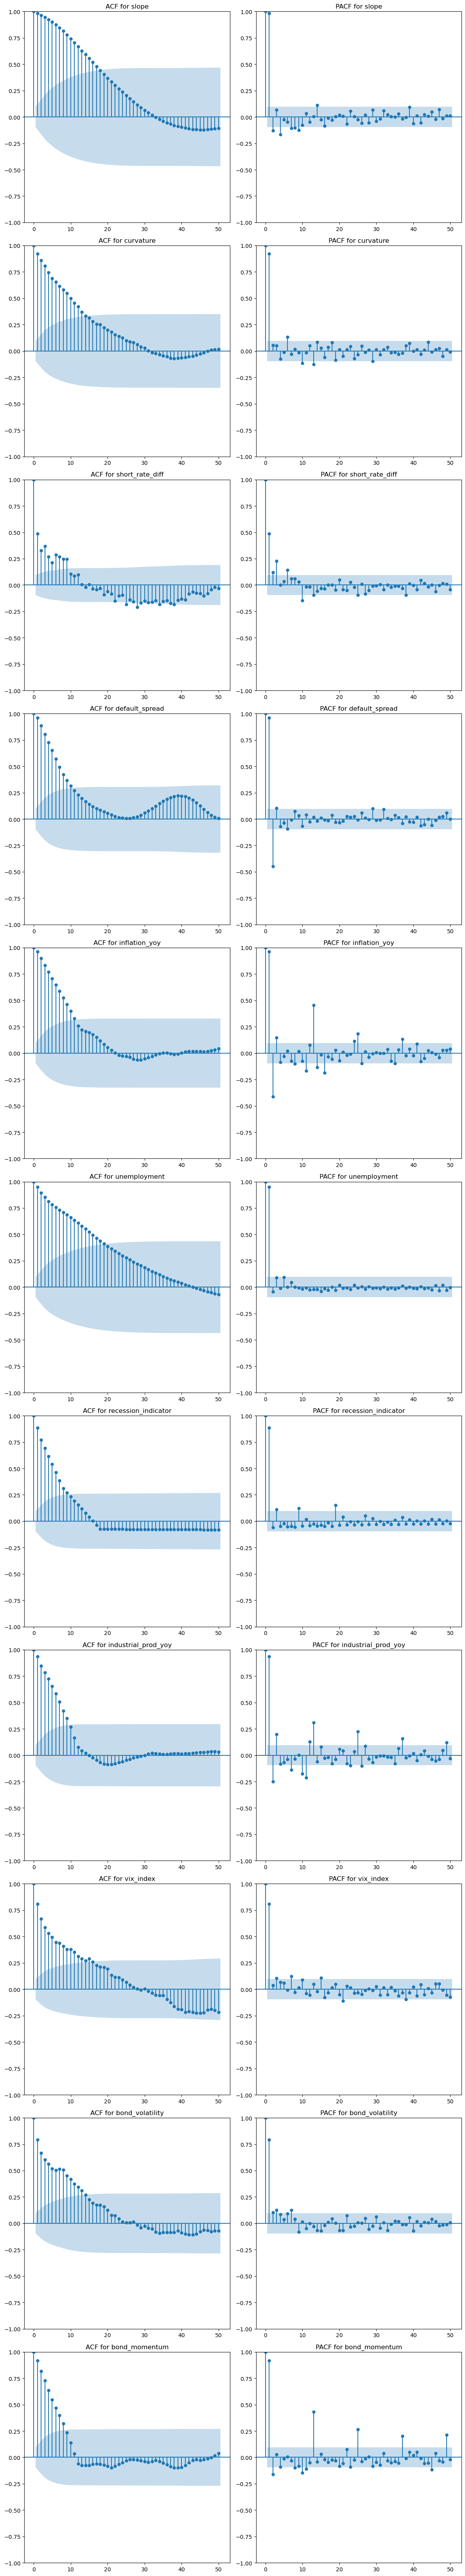

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# List of predictors to analyze
predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment',
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

# Create subplots for ACF and PACF of each predictor
fig, axes = plt.subplots(len(predictors), 2, figsize=(12, 6 * len(predictors)))

for i, predictor in enumerate(predictors):
    # ACF plot
    plot_acf(df_final[predictor].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'ACF for {predictor}')

    # PACF plot
    plot_pacf(df_final[predictor].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'PACF for {predictor}')

plt.tight_layout()
plt.show()



### 2.8 PCA for Dimensionality Reduction

As shown in correlation analysis, we found siginificant multicollinearity between the predictors.

Here, we do PCA to transform the 11 predictors into new orthogonal (uncorrelated) principal components.

In [34]:
predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment',
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum',
              'excess_return_lag1']

# we need to standardize before PCA
X = df_final[predictors]
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# fit PCA
pca = PCA()
pcs = pca.fit_transform(X_standardized)

# create a df for the PCs
pc_cols = [f'PC{i+1}' for i in range(len(predictors))]
df_pca = pd.DataFrame(pcs, columns=pc_cols, index=df_final.index)

In [36]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig_scree = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# of Components", "y": "Cumulative Explained Variance"},
    title="Scree Plot: Variance Explained by Principal Components",
    template='plotly_white'
)
fig_scree.add_hline(y=0.9, line_dash="dash", annotation_text="90% Variance Threshold")
fig_scree.add_hline(y=0.8, line_dash="dash", annotation_text="80% Variance Threshold")
fig_scree.add_hline(y=0.7, line_dash="dash", annotation_text="70% Variance Threshold")
fig_scree.show()

From the plot, we know can conclude that:
- The first 5 PCs explain ~74% variation of the data
- The first 6 PCs explain ~81% variation of the data
- The first 8 PCs explain ~90% variation of the data

In [37]:
# loadings heatmap: to interpret the components economically
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pc_cols,
    index=predictors
)

fig_loadings = px.imshow(
    loadings.iloc[:, :8],
    aspect="auto",
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1,
    title="PCA Loadings: Identifying Economic Themes",
    labels=dict(color="Weight"), width = 1100, height = 500
)
fig_loadings.show()

The above loading heatmaps allow us to understand the correlation of each PC with the raw variables.

Later, we will use this PCA component for modelling. We will compare whether using raw features vs PCs give better predictive result.

| Feature type | Advantage | Trade-off |
|--------------|-----------|-----------|
| Raw Standardized Feature | High Economic Intuition because coefficients are directly linked to variables | Suffering from Multicollinearity. OLS estimates can be unstable and standard errors inflated |
| Principal Components (PCs) | PCs are orthogonal, so help in stabilising model | Not really interprettable |

- **TO DO LATER: analyze how we can interpret the first 5 PCs**

### 2.9 Standardization

do standardization on `df_final`
do not do standardization on `df_pca`

In [38]:
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
X_standardized = scaler.fit_transform(df_final[predictors])

# a new dataframe with standardized values
df_standardized = pd.DataFrame(X_standardized, columns=predictors, index=df_final.index)

## OLS Baseline

### OLS Model

For OLS Baseline, please use 2 type of data for comparison:
- Raw standardized feature
- Principal Components

### a. Principal Components (first 4)

In [64]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

# First 4 components
X_pca = df_pca.iloc[:, :4]

# add constants
X_pca = sm.add_constant(X_pca)

# y
y = df_final['excess_return']

# OLS
ols_model_pca = sm.OLS(y, X_pca).fit()

# Part1. MAE
y_pred = ols_model_pca.predict(X_pca)
mae = mean_absolute_error(y, y_pred)
print(f'Mean Absolute Error (MAE) for PCA (4): {mae}')

# Part2. Hit Ratio (Directional Accuracy)
# the directional change for the actual and predicted values
y_change = np.sign(y.diff().iloc[1:])  #Change in actual values
y_pred_change = np.sign(y_pred.diff().iloc[1:])  # Change in predicted values
hit_ratio = np.mean(y_change == y_pred_change)  # Compare the signs
print(f'Hit Ratio (Directional Accuracy) for PCA (4): {hit_ratio}')

# summary
print(ols_model_pca.summary())


Mean Absolute Error (MAE) for PCA (4): 0.01799887115657643
Hit Ratio (Directional Accuracy) for PCA (4): 0.4230769230769231
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.035
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0887
Time:                        17:23:42   Log-Likelihood:                 974.85
No. Observations:                 417   AIC:                            -1940.
Df Residuals:                     412   BIC:                            -1920.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

#### Out of sample for model a.

In [65]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Train:test-8:2
train_size = int(len(df_pca) * 0.8)
X_train, X_test = df_pca[:train_size], df_pca[train_size:]
y_train, y_test = df_final['excess_return'][:train_size], df_final['excess_return'][train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca = sm.add_constant(X_train_pca)
X_test_pca = sm.add_constant(X_test_pca)

# OLS model
ols_model_pca = sm.OLS(y_train, X_train_pca).fit()

print(ols_model_pca.summary())

# Prediction
y_pred = ols_model_pca.predict(X_test_pca)

# Part1: MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE) for PCA (4) OOS: {mae}')

# Part2: Hit Ratio (Directional Accuracy)
y_change = np.sign(y_test.diff().iloc[1:])
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_change = np.sign(y_pred_series.diff().iloc[1:])

hit_ratio = np.mean(y_change == y_pred_change)
print(f'Hit Ratio (Directional Accuracy)for PCA (4) OOS: {hit_ratio}')


                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.1572
Date:                Wed, 11 Feb 2026   Prob (F-statistic):              0.960
Time:                        17:23:46   Log-Likelihood:                 777.76
No. Observations:                 333   AIC:                            -1546.
Df Residuals:                     328   BIC:                            -1526.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.340      0.0

### b. Principal Components (first 8)

In [66]:
import statsmodels.api as sm

# First 8 components
X_pca = df_pca.iloc[:, :8]

# add constants
X_pca = sm.add_constant(X_pca)

# y
y = df_final['excess_return']

# OLS
ols_model_pca = sm.OLS(y, X_pca).fit()

# Part1. MAE
y_pred = ols_model_pca.predict(X_pca)
mae = mean_absolute_error(y, y_pred)
print(f'Mean Absolute Error (MAE) for PCA (8): {mae}')

# Part2. Hit Ratio (Directional Accuracy)
# the directional change for the actual and predicted values
y_change = np.sign(y.diff().iloc[1:])  #Change in actual values
y_pred_change = np.sign(y_pred.diff().iloc[1:])  # Change in predicted values
hit_ratio = np.mean(y_change == y_pred_change)  # Compare the signs
print(f'Hit Ratio (Directional Accuracy) for PCA (8): {hit_ratio}')

# summary
print(ols_model_pca.summary())

Mean Absolute Error (MAE) for PCA (8): 0.017905740643130497
Hit Ratio (Directional Accuracy) for PCA (8): 0.39903846153846156
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.767
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0819
Time:                        17:23:49   Log-Likelihood:                 977.87
No. Observations:                 417   AIC:                            -1938.
Df Residuals:                     408   BIC:                            -1901.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

#### Out of sample for model b.

In [67]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Train:test-8:2
train_size = int(len(df_pca) * 0.8)
X_train, X_test = df_pca[:train_size], df_pca[train_size:]
y_train, y_test = df_final['excess_return'][:train_size], df_final['excess_return'][train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca = sm.add_constant(X_train_pca)
X_test_pca = sm.add_constant(X_test_pca)

# OLS model
ols_model_pca = sm.OLS(y_train, X_train_pca).fit()

print(ols_model_pca.summary())

# Prediction
y_pred = ols_model_pca.predict(X_test_pca)

# Part1: MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE) for PCA(8) OOS: {mae}')

# Part2: Hit Ratio (Directional Accuracy)
y_change = np.sign(y_test.diff().iloc[1:])
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_change = np.sign(y_pred_series.diff().iloc[1:])

hit_ratio = np.mean(y_change == y_pred_change)
print(f'Hit Ratio (Directional Accuracy for PCA (8) OOS): {hit_ratio}')


                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.153
Date:                Wed, 11 Feb 2026   Prob (F-statistic):              0.328
Time:                        17:23:52   Log-Likelihood:                 782.12
No. Observations:                 333   AIC:                            -1546.
Df Residuals:                     324   BIC:                            -1512.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.357      0.0

These two OLS models built by principal components perform poorly, with very low R-squared and insignificant p-values for most principal components.

### c. Raw Standardized Feature

In [68]:
import statsmodels.api as sm

# Predictors and target
X = df_standardized
X = sm.add_constant(X)
y = df_final['excess_return']

# OLS model
ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.570
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0977
Time:                        17:23:57   Log-Likelihood:                 980.28
No. Observations:                 417   AIC:                            -1935.
Df Residuals:                     404   BIC:                            -1882.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0021    

#### Evaluation

Mean Absolute Error (MAE) for raw standardized: 0.01790703793882266
Hit Ratio (Directional Accuracy) for raw standardized: 0.43509615384615385


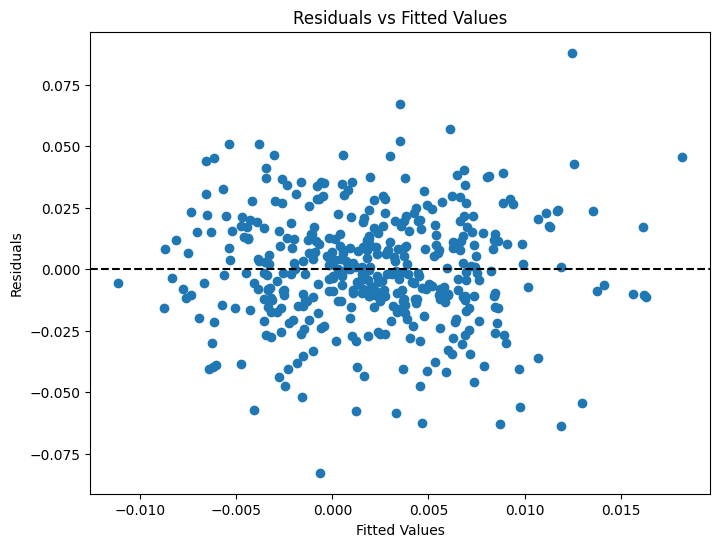

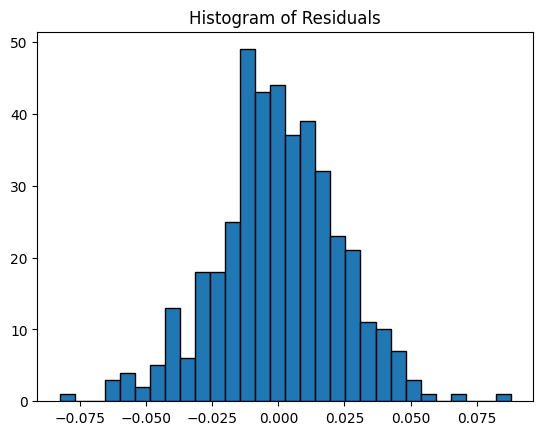

In [69]:

# Part1. MAE
y_pred = ols_model.predict(X)
mae = mean_absolute_error(y, y_pred)
print(f'Mean Absolute Error (MAE) for raw standardized: {mae}')

# Part2. Hit Ratio (Directional Accuracy)
# the directional change for the actual and predicted values
y_change = np.sign(y.diff().iloc[1:])  #Change in actual values
y_pred_change = np.sign(y_pred.diff().iloc[1:])  # Change in predicted values
hit_ratio = np.mean(y_change == y_pred_change)  # Compare the signs
print(f'Hit Ratio (Directional Accuracy) for raw standardized: {hit_ratio}')

# Part3. Residuals plot-check for homoscedasticity
residuals = ols_model.resid

plt.figure(figsize=(8, 6))
plt.scatter(ols_model.fittedvalues, residuals)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals for normality check
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.show()

#### Out of sample for model c.

In [70]:
# Train:Test = 8:2
train_size = int(len(df_standardized) * 0.8)
X_train, X_test = df_standardized[:train_size], df_standardized[train_size:]
y_train, y_test = df_final['excess_return'][:train_size], df_final['excess_return'][train_size:]

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

#OLS model
ols_model = sm.OLS(y_train, X_train).fit()
print(ols_model.summary())

# Prediction
y_pred = ols_model.predict(X_test)

# Part 1: MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Part 2: Hit Ratio (Directional Accuracy)
y_change = np.sign(y_test.diff().iloc[1:])
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_change = np.sign(y_pred_series.diff().iloc[1:])

hit_ratio = np.mean(y_change == y_pred_change)
print(f'Hit Ratio (Directional Accuracy): {hit_ratio}')


                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.233
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0103
Time:                        17:24:03   Log-Likelihood:                 790.84
No. Observations:                 333   AIC:                            -1556.
Df Residuals:                     320   BIC:                            -1506.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0026    

**OLS Model Conclusion:**

**1. PCA (4)**


**MAE:** 0.018, which is low, indicating the model has a good fit.

**Hit Ratio:** 0.423, suggesting good directional accuracy, meaning the model has strong prediction directionality.

**R-squared:** 0.019, which is low, indicating that the model's overall fit is poor and it cannot explain the variability of the data well.

**PCA (4) OOS:**

**MAE:** 0.019, still relatively low.

**Hit Ratio:** Significantly increased to 0.506, suggesting better directional accuracy in predicting the test set and good generalization ability.

**R-squared:** Very low at 0.002, indicating the model's fit to the OOS data is very poor and it cannot explain the test set data well.


---



**2. PCA (8)**

**MAE:** 0.018, which is similar to PCA (4)'s error.

**Hit Ratio:** 0.399, slightly lower than PCA (4).

**R-squared:** 0.033, showing a slight improvement compared to PCA (4)'s R² of 0.019, indicating slightly better fit on the training set.

**PCA (8) OOS:**

**MAE:** 0.019, similar to PCA (4).

**Hit Ratio:** 0.373, directional accuracy on the test set is lower than PCA (4).

**R-squared:** 0.028, slightly higher than PCA (4), but still very low.

---



**3. Raw Standardized Features**

**MAE:** 0.018, similar results across all three models.

**Hit Ratio:** 0.435, slightly higher than PCA (4) and PCA (8), indicating relatively better directional accuracy.

**R-squared:** 0.045, significantly higher than PCA (4) and PCA (8), indicating the model has a stronger fit.

**Raw Standardized Features OOS:**

**MAE:** Increased to 0.022, slightly higher than PCA (4) and PCA (8), but still acceptable.

**Hit Ratio:** 0.482, performing well, close to PCA (4)'s OOS performance, with good directional accuracy.

**R-squared:** 0.077, which is higher, indicating the model has a strong fit on the OOS data set.

The residuals appear to be fairly well-behaved, but there might be issues like heteroscedasticity (non-constant variance) or other patterns that might need more sophisticated models like Random Forests or XGBoost for better predictive performance.

Many predictors have high p-values, indicating that they do not contribute significantly to explaining bond returns. This could mean that either the predictors chosen are not suitable for modeling bond returns or that there is insufficient data to detect their effect.



## Other ML Modelling

For modelling, please use 2 type of data for comparison:
- Raw standardized feature
- Principal Components

Do not forget to do hyperparameter tuning using gridSearch

## Benchmark: expanding window naive mean
The benchmark forecast at time t is the historical mean of excess returns computed over all observations available up to t−1 (expanding window).

This choice reflects the standard no-predictability null in return forecasting and allows the unconditional mean to adjust gradually over time, which is appropriate in a time-series setting where bond risk premia may shift across regimes.

In [114]:
import numpy as np
import pandas as pd

# Keep time order (no look-ahead)
X = df_final[predictors].sort_index()
y = df_final.loc[X.index, "excess_return"]

initial_train_size = int(len(y) * 0.6)

y_true = []
y_bench = []

# Expanding-window mean benchmark: forecast at t is mean(y[0:t])
for t in range(initial_train_size, len(y)):
    y_train = y.iloc[:t]
    y_test = y.iloc[t]

    y_true.append(y_test)
    y_bench.append(y_train.mean())

y_true_oos = np.asarray(y_true)
y_bench_oos = np.asarray(y_bench)

mse_bench = np.mean((y_true_oos - y_bench_oos) ** 2)
rmse_bench = np.sqrt(mse_bench)

print(f"Expanding-window benchmark RMSE:{rmse_bench:.6f}")
print("Benchmark OOS R²: 0.00% (by definition)")

Expanding-window benchmark RMSE:0.021040
Benchmark OOS R²: 0.00% (by definition)


## OLS under expanding window framework
At each forecast origin, excess returns are regressed on the 12 lagged predictors using OLS, with coefficients re-estimated recursively under an expanding-window scheme. Predictors are standardized within each training window, and forecasts are generated one period ahead using only information available at the time.

In [115]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Time ordering
X = df_final[predictors].sort_index()
y = df_final.loc[X.index, "excess_return"]

initial_train_size = int(len(X) * 0.6)

y_true = []
y_pred = []
y_bench = []

for t in range(initial_train_size, len(X)):

    X_train = X.iloc[:t]
    y_train = y.iloc[:t]
    X_test  = X.iloc[t:t+1]
    y_test  = y.iloc[t]

    # Scale using training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # OLS
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_hat = model.predict(X_test_scaled)[0]

    # Expanding-mean benchmark
    y_mean = y_train.mean()

    y_true.append(y_test)
    y_pred.append(y_hat)
    y_bench.append(y_mean)

# Arrays
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)
y_bench = np.asarray(y_bench)

# OOS R²
ss_res = np.sum((y_true - y_pred) ** 2)
ss_bench = np.sum((y_true - y_bench) ** 2)
r2_oos = 1 - ss_res / ss_bench

print(f"OLS Expanding-window OOS R²: {r2_oos * 100:.2f}%")

# RMSE
rmse_ols = np.sqrt(np.mean((y_true - y_pred) ** 2))
rmse_bench = np.sqrt(np.mean((y_true - y_bench) ** 2))

print(f"OLS RMSE: {rmse_ols:.6f}")
print(f"Benchmark RMSE: {rmse_bench:.6f}")


OLS Expanding-window OOS R²: -7.47%
OLS RMSE: 0.021812
Benchmark RMSE: 0.021040


OLS underperforms the expanding-mean benchmark in the expanding-window evaluation, delivering a negative OOS R² (−7.47%) and a higher RMSE than the benchmark. This indicates that the unrestricted linear model adds estimation noise without capturing sufficient predictive signal, reinforcing the importance of regularization in this low signal-to-noise environment.

## Elastic Net under expanding window framework
We estimate an Elastic Net regression in an expanding-window framework, tuning (alpha, l1 ratio) each period using a time-series cross-validation split on the training window only (minimizing MSE). Predictors are standardized within each training window to ensure shrinkage penalties are comparable across variables and to avoid look-ahead bias.

### Libraries and Data preparation

In [116]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

X = df_final[predictors].sort_index()
y = df_final.loc[X.index, 'excess_return']

### Model implementation

In [117]:
y_pred_list_en = []
best_params_list_en = []

inner_splits_target_en = 5

alpha_grid_en = np.logspace(-4, 1, 15)
l1_ratio_grid_en = [0.05, 0.1, 0.2, 0.5, 0.8]

param_grid_en = {"alpha": alpha_grid_en, "l1_ratio": l1_ratio_grid_en}

for t in range(initial_train_size, len(X)):

    X_train_en = X.iloc[:t]
    y_train_en = y.iloc[:t]
    X_test_en  = X.iloc[t:t+1]

    # Standardize X on training only (required for EN)
    scaler_en = StandardScaler()
    X_train_scaled_en = scaler_en.fit_transform(X_train_en)
    X_test_scaled_en  = scaler_en.transform(X_test_en)

    # TimeSeries CV on training only
    n_train_en = len(X_train_en)
    n_splits_en = min(inner_splits_target_en, max(2, n_train_en // 40))
    if n_splits_en < 2:
        n_splits_en = 2

    tscv_en = TimeSeriesSplit(n_splits=n_splits_en)

    en = ElasticNet(fit_intercept=True, max_iter=10000, random_state=42, selection="cyclic")

    grid_en = GridSearchCV(
        en,
        param_grid_en,
        cv=tscv_en,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid_en.fit(X_train_scaled_en, y_train_en)

    best_en = grid_en.best_estimator_
    best_params_list_en.append(grid_en.best_params_)

    # 1-step ahead prediction
    y_pred_en = best_en.predict(X_test_scaled_en)[0]
    y_pred_list_en.append(y_pred_en)

# Convert to array 
y_pred_oos_en = np.array(y_pred_list_en)


Lengths -> y_true_oos: 167 | y_pred_oos_en: 167 | y_bench_oos: 167


### Model OOS Evaluation 

In [118]:
# OOS R² vs benchmark (expanding mean)
ss_res_en = np.sum((y_true_oos - y_pred_oos_en) ** 2)
ss_bench  = np.sum((y_true_oos - y_bench_oos) ** 2)

r2_oos_en = 1 - ss_res_en / ss_bench

mse_en = np.mean((y_true_oos - y_pred_oos_en) ** 2)
rmse_en = np.sqrt(mse_en)

print(f"Elastic Net Expanding-window OOS R²: {r2_oos_en*100:.2f}%")
print(f"Elastic Net RMSE: {rmse_en:.6f}")
print(f"Benchmark RMSE: {rmse_bench:.6f}")


Elastic Net Expanding-window OOS R²: 0.00%
Elastic Net RMSE: 0.021040
Benchmark RMSE: 0.021040


### Hyperparameters diagnostics

In [119]:
best_params_df_en = pd.DataFrame(best_params_list_en)
print(best_params_df_en.tail())
print("\nMode:")
print(best_params_df_en.mode().iloc[0])
print("\nMean alpha:", best_params_df_en["alpha"].astype(float).mean())
print("Mean l1_ratio:", best_params_df_en["l1_ratio"].astype(float).mean())


        alpha  l1_ratio
162  0.006105       0.8
163  0.006105       0.8
164  0.006105       0.8
165  0.006105       0.8
166  0.006105       0.8

Mode:
alpha       0.006105
l1_ratio    0.800000
Name: 0, dtype: float64

Mean alpha: 0.026588906019351717
Mean l1_ratio: 0.5544910179640716


### Predictions diagnostics

In [120]:
diff = y_pred_oos_en - y_bench_oos

print("Max |pred - bench|:", np.max(np.abs(diff)))
print("Mean |pred - bench|:", np.mean(np.abs(diff)))
print("% exactly equal (float):", np.mean(y_pred_oos_en == y_bench_oos) * 100)

# Correlation (if constant/near-constant, corr can be weird)
print("Corr(pred, bench):", np.corrcoef(y_pred_oos_en, y_bench_oos)[0,1])

Max |pred - bench|: 0.0
Mean |pred - bench|: 0.0
% exactly equal (float): 100.0
Corr(pred, bench): 1.0


Elastic Net collapses to an intercept-only specification under expanding-window cross-validation, yielding forecasts identical to the expanding-mean benchmark. Once regularization is imposed, linear combinations of the macro predictors provide no incremental out-of-sample predictive power. This result underscores that Treasury excess return predictability is weak and diffuse, and that shrinkage-based linear models struggle to improve meaningfully on the historical mean in this setting.

## Neural network under expanding window framework

### Libraries and Data preparation

In [121]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import loguniform

random_state = 42  # replicability

# Ensure chronological order (no look-ahead)
X = df_final[predictors].sort_index()
y = df_final.loc[X.index, "excess_return"]


### Expanding window set up
less sensitive to regime changes and arbitrary split

In [122]:
initial_train_size = int(len(X) * 0.6)   # 60% initial training sample
inner_splits_target = 5                  # target number of time-series CV splits

# Efficiency controls
TUNE_EVERY = 3                           # tune hyperparameters every k steps

# Storage
y_true_list, y_pred_list, y_bench_list = [], [], []
best_params_list = []

last_best_params = None


### Hyperparameter space

In [123]:
param_distributions = {
    "hidden_layer_sizes": [(2,), (3,), (4,), (6,), (12,)],
    "alpha": loguniform(1e-4, 1e2),                         # L2 shrinkage
    "learning_rate_init": loguniform(1e-4, 5e-3),           # Adam learning rate
}

### Model implementation
The target return is standardized within each training window to stabilize NN optimization; forecasts are then mapped back to return units via the inverse transform.

In [124]:
for step, t in enumerate(range(initial_train_size, len(X))):

    # ---- Expanding split ----
    X_train = X.iloc[:t]
    y_train = y.iloc[:t]
    X_test  = X.iloc[t:t+1]
    y_test  = y.iloc[t:t+1]

    # ---- Scale using training window only ----
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train_s = X_scaler.fit_transform(X_train)
    X_test_s  = X_scaler.transform(X_test)

    y_train_s = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()

    # ---- Expanding-mean benchmark ----
    y_mean = y_train.mean()

    # ---- Adaptive TimeSeriesSplit (training only) ----
    n_train = len(X_train)
    n_splits = min(inner_splits_target, max(2, n_train // 40))
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # ---- Base MLP (fixed structural choices) ----
    base_mlp = MLPRegressor(
        activation="relu",
        solver="adam",
        max_iter=3000,
        early_stopping=False,   # avoid random validation split
        tol=1e-4,
        n_iter_no_change=20,
        random_state=random_state,
    )

    # ---- Nested tuning (successive halving) ----
    do_tune = (step % TUNE_EVERY == 0) or (last_best_params is None)

    if do_tune:
        search = HalvingRandomSearchCV(
            estimator=base_mlp,
            param_distributions=param_distributions,
            cv=tscv,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            random_state=random_state,

            # successive halving controls
            factor=3,
            resource="max_iter",
            max_resources=3000,
            min_resources=200,
        )

        search.fit(X_train_s, y_train_s)

        best_mlp = search.best_estimator_
        last_best_params = search.best_params_

    else:
        best_mlp = base_mlp.set_params(**last_best_params)
        best_mlp.fit(X_train_s, y_train_s)

    best_params_list.append(last_best_params)

    # ---- 1-step-ahead forecast (back to return units) ----
    y_pred_s = best_mlp.predict(X_test_s)[0]
    y_pred = y_scaler.inverse_transform([[y_pred_s]])[0, 0]

    # ---- Store ----
    y_true_list.append(y_test.values[0])
    y_pred_list.append(y_pred)
    y_bench_list.append(y_mean)


/Users/guillaumetoulza/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/guillaumetoulza/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/guillaumetoulza/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/guillaumetoulza/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

### Model OOS evaluation

In [125]:
y_true_oos  = np.asarray(y_true_list)
y_pred_oos  = np.asarray(y_pred_list)
y_bench_oos = np.asarray(y_bench_list)

ss_res = np.sum((y_true_oos - y_pred_oos) ** 2)
ss_bench = np.sum((y_true_oos - y_bench_oos) ** 2)

r2_oos = 1 - ss_res / ss_bench

mse_mlp = np.mean((y_true_oos - y_pred_oos) ** 2)
rmse_mlp = np.sqrt(mse_mlp)

mse_bench = np.mean((y_true_oos - y_bench_oos) ** 2)
rmse_bench = np.sqrt(mse_bench)

print(f"MLP Expanding-window OOS R² (tuned via HalvingRandomSearchCV+TSCV): {r2_oos*100:.2f}%")
print(f"MLP RMSE: {rmse_mlp:.6f}")
print(f"Benchmark RMSE: {rmse_bench:.6f}")


MLP Expanding-window OOS R² (tuned via HalvingRandomSearchCV+TSCV): 0.69%
MLP RMSE: 0.020967
Benchmark RMSE: 0.021040


The tuned MLP delivers a modest but positive improvement over the expanding-mean benchmark, achieving an OOS R² of 0.69% and a slightly lower RMSE. While the statistical gain is small, it indicates that a carefully regularized nonlinear model can extract limited incremental predictive signal in this low signal-to-noise Treasury return setting.

### Hyperparameter diagnostics

In [126]:
best_params_df = pd.DataFrame(best_params_list)

print("\nMost common chosen hyperparameters (mode):")
print(best_params_df.mode().iloc[0])


Most common chosen hyperparameters (mode):
alpha                 65.987111
hidden_layer_sizes         (6,)
learning_rate_init     0.003932
max_iter                   1800
Name: 0, dtype: object


### Permutation importance
Permutation importance is computed for the final expanding-window model (i.e., the model estimated using the largest available training sample), evaluated over the OOS period.

In [127]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# ---- Data (chronological order) ----
X = df_final[predictors].sort_index()
y = df_final.loc[X.index, "excess_return"]

initial_train_size = int(len(X) * 0.6)

# ---- Modal tuned hyperparameters (from Halving search) ----
MLP_PARAMS = dict(
    hidden_layer_sizes=(6,),
    alpha=65.987111,
    learning_rate_init=0.003932,
    activation="relu",
    solver="adam",
    max_iter=1800,
    early_stopping=False,
    tol=1e-4,
    n_iter_no_change=20,
    random_state=42,
)

# ---- Final expanding-window fit (largest training sample) ----
# Use all data up to the last OOS point
X_train = X.iloc[:-1]
y_train = y.iloc[:-1]

X_oos = X.iloc[initial_train_size:]
y_oos = y.iloc[initial_train_size:]

# ---- Scale using training window only ----
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_s = X_scaler.fit_transform(X_train)
y_train_s = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()

X_oos_s = X_scaler.transform(X_oos)

# ---- Fit final MLP ----
mlp = MLPRegressor(**MLP_PARAMS)
mlp.fit(X_train_s, y_train_s)

# ---- Baseline OOS MSE ----
y_pred_s = mlp.predict(X_oos_s)
y_pred = y_scaler.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()

baseline_mse = np.mean((y_oos.to_numpy() - y_pred) ** 2)
print(f"Baseline OOS MSE: {baseline_mse:.8f}")

# ---- Permutation importance (shuffle one feature at a time) ----
rng = np.random.default_rng(42)
n_repeats = 30  # increase (e.g., 50) for more stability

feature_names = list(X.columns)
rows = []

for j, feat in enumerate(feature_names):

    mses = []

    for _ in range(n_repeats):
        X_perm = X_oos_s.copy()
        X_perm[:, j] = rng.permutation(X_perm[:, j])

        y_perm_s = mlp.predict(X_perm)
        y_perm = y_scaler.inverse_transform(y_perm_s.reshape(-1, 1)).ravel()

        mse_perm = np.mean((y_oos.to_numpy() - y_perm) ** 2)
        mses.append(mse_perm)

    mses = np.asarray(mses)

    rows.append({
        "feature": feat,
        "delta_mse_mean": mses.mean() - baseline_mse,
        "delta_mse_std": mses.std(ddof=1),
        "delta_mse_pct": 100 * (mses.mean() - baseline_mse) / baseline_mse,
    })

imp_df = (
    pd.DataFrame(rows)
    .sort_values("delta_mse_mean", ascending=False)
    .reset_index(drop=True)
)

display(imp_df)

Baseline OOS MSE: 0.00043707


,feature,delta_mse_mean,delta_mse_std,delta_mse_pct
0,slope,4.647166e-09,2.833767e-09,0.001063
1,curvature,3.854470e-09,3.357419e-09,0.000882
2,inflation_yoy,2.812452e-09,1.932177e-09,0.000643
3,excess_return_lag1,2.600839e-09,3.083105e-09,0.000595
4,short_rate_diff,2.236110e-09,1.717666e-09,0.000512
5,bond_volatility,9.098154e-10,1.082305e-09,0.000208
6,unemployment,5.684963e-10,1.836561e-09,0.000130
7,industrial_prod_yoy,4.436161e-10,1.554328e-09,0.000101
8,default_spread,1.350065e-10,1.621015e-10,0.000031
9,recession_indicator,1.486193e-11,1.237424e-10,0.000003


Permutation importance indicates that yield curve factors (slope and curvature) are the most influential inputs for the MLP, followed by inflation and lagged excess returns. However, the absolute impact on OOS MSE is extremely small and broadly distributed across predictors, consistent with the modest overall OOS R2 and the strong regularization of the network. No single variable meaningfully drives predictive performance, and several features exhibit near-zero or slightly negative importance, suggesting limited exploitable nonlinear structure. Taken together, these results imply that additional feature selection or dimensionality-reduction techniques are unlikely to materially improve predictive performance in this low signal-to-noise setting.

## Economic significance

In [129]:
def utility_gain(y_true, y_hat, y_bench, gamma=5, cap=1.0, cost_bps=0.0):
    # variance estimate (use realized OOS variance as simple proxy)
    sigma2 = np.var(y_true, ddof=1)

    # weights
    w_hat = y_hat / (gamma * sigma2)
    w_bench = y_bench / (gamma * sigma2)

    # cap leverage
    w_hat = np.clip(w_hat, -cap, cap)
    w_bench = np.clip(w_bench, -cap, cap)

    # realized portfolio returns
    rp_hat = w_hat * y_true
    rp_bench = w_bench * y_true

    # transaction costs (bps per unit turnover)
    if cost_bps > 0:
        tc = (cost_bps / 10000.0) * np.abs(np.diff(w_hat, prepend=w_hat[0]))
        rp_hat = rp_hat - tc

    CE_hat = np.mean(rp_hat) - 0.5 * gamma * np.var(rp_hat, ddof=1)
    CE_bench = np.mean(rp_bench) - 0.5 * gamma * np.var(rp_bench, ddof=1)

    return (CE_hat - CE_bench) * 12  # annualized

for g in [3, 5, 10]:
    val = utility_gain(y_true_oos, y_pred_oos, y_bench_oos,
                       gamma=g, cap=1.0, cost_bps=0.0)
    print(f"gamma {g} ΔCE (cap=1, no costs): {val:.4f}")

val_cost = utility_gain(y_true_oos, y_pred_oos, y_bench_oos,
                        gamma=5, cap=1.0, cost_bps=10)

print(f"ΔCE with costs (10 bps turnover): {val_cost:.4f}")

gamma 3 ΔCE (cap=1, no costs): 0.0010
gamma 5 ΔCE (cap=1, no costs): 0.0052
gamma 10 ΔCE (cap=1, no costs): 0.0048
ΔCE with costs (10 bps turnover): 0.0046


Relative to an expanding-mean forecast benchmark, the ML timing strategy increases certainty equivalent utility by ~50 bps/year for γ in {5,10}, and remains positive after a 10 bps turnover cost. A 50 bps CE gain means that a mean–variance investor would be indifferent between using the ML strategy and earning an additional 0.5% per year with no extra risk under the benchmark. The estimated 50 bps annual certainty-equivalent gain is economically meaningful relative to the expanding-mean benchmark. In fixed-income markets, where incremental alpha is often measured in tens of basis points, an improvement of this magnitude can be material. For example, for an institutional investor managing 10 billion in Treasury exposure, a 50 bps gain corresponds to approximately 50 million in additional annual value. However, the benchmark represents a statistical reference rather than a fully implementable investment strategy, so the practical relevance ultimately depends on robustness and comparison to realistic passive or active alternatives.

### Limitations

Neural networks face several limitations in this Treasury bond return forecasting exercise. First, the available sample is relatively small (monthly macroeconomic data), making high-capacity models prone to overfitting and unstable parameter estimates. Second, Treasury excess returns exhibit a low signal-to-noise ratio, and both linear and nonlinear models deliver only modest incremental predictive power out of sample. The weak performance of OLS and the Elastic Net’s collapse to an intercept-only specification indicate that robust linear structure is limited, while the MLP’s small but positive improvement suggests that any exploitable nonlinear signal is diffuse rather than concentrated. Third, neural networks can be sensitive to structural breaks and regime shifts, potentially amplifying sample instability.

To mitigate these concerns, we restrict model complexity (small architectures), impose strong L2 regularization, employ nested time-series cross-validation with successive halving to control overfitting, and evaluate performance strictly through expanding-window out-of-sample forecasts relative to an expanding-mean benchmark. These design choices aim to ensure that any measured improvement reflects genuine predictive content rather than sample-specific overfitting.

## Benchmark(Rolling-Window Mean Benchmark)
To establish a baseline for evaluating the predictive performance of our machine learning models, we implement a simple yet widely used benchmark: the rolling-window historical mean. This benchmark predicts the excess return for day t as the average of the excess returns observed over a fixed window of the most recent W trading days prior to t.
This benchmark is the reference point: It provides a lower bound for model performance. Any sophisticated model must outperform this simple historical average to justify its complexity.

The out-of-sample root mean squared error (RMSE) of this rolling-window benchmark is computed and will serve as the baseline against which all subsequent models are compared.

In [48]:
import numpy as np
import pandas as pd

# Keep time order (no look-ahead)
X = df_final[predictors].sort_index()
y = df_final.loc[X.index, "excess_return"]

# set parameter
initial_train_size = int(len(y) * 0.6)  
window_size = 252  # size for rolling windows

y_true = []
y_bench_roll = []  
  

# Rolling-window mean benchmark: forecast at t is mean(y[t-window_size:t])
for t in range(initial_train_size, len(y)):
    y_test = y.iloc[t]
    
    if t >= window_size:
        y_train_roll = y.iloc[t-window_size:t]  
    else:
        y_train_roll = y.iloc[:t]  
    
    
    # results
    y_true.append(y_test)
    y_bench_roll.append(y_train_roll.mean())  # 
    

y_true_oos = np.asarray(y_true)
y_bench_roll_oos = np.asarray(y_bench_roll)


# RMSE
mse_bench_roll = np.mean((y_true_oos - y_bench_roll_oos) ** 2)
rmse_bench_roll = np.sqrt(mse_bench_roll)



# output
print(f"=== Rolling-window (window_size={window_size}) ===")
print(f"Rolling-window RMSE: {rmse_bench_roll:.6f}")
print(f"Rolling-window R²: 0.00% (by definition)")


=== Rolling-window (window_size=252) ===
Rolling-window RMSE: 0.020973
Rolling-window R²: 0.00% (by definition)


## Random Forest
We estimate a Random Forest regression in an expanding-window framework. For each period, the model is trained using only information available up to that point, ensuring a realistic out-of-sample forecasting exercise.Here are some details about RF.

Expanding window: The initial training set consists of the first 60% of observations. For each subsequent period t,he model is trained on all data from the beginning up to time t−1, and then used to predict the excess return at time t.

Benchmark comparison: The predictive performance of Random Forest is evaluated against a simple expanding-window historical mean benchmark. This allows us to assess whether the model captures any predictable patterns beyond the unconditional average return.

Out-of-sample evaluation: Forecast accuracy is measured using Root Mean Squared Error (RMSE) and out-of-sample R².

In [50]:
# Tree-based models from scikit-learn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model selection and preprocessing
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Set plot style and random seed for reproducibility
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("Libraries loaded!")

Libraries loaded!


In [53]:
# Define the out-of-sample R² function (same as Week 2)

def oos_r2(y_true, y_pred, y_train_mean):
    """
    Calculate out-of-sample R² relative to the historical mean benchmark.
    
    R²_OOS = 1 - (Sum of Squared Errors) / (Total Sum of Squares)
    
    - Positive R²: Model beats the historical mean
    - Negative R²: Model is WORSE than just predicting the mean
    - Zero R²: Model equals the historical mean
    
    Parameters:
    -----------
    y_true : array-like, actual returns
    y_pred : array-like, predicted returns
    y_train_mean : float, historical mean from training data
    
    Returns:
    --------
    float : out-of-sample R²
    """
    ss_res = np.sum((y_true - y_pred)**2)          # Sum of squared residuals (model errors)
    ss_tot = np.sum((y_true - y_train_mean)**2)    # Total sum of squares (benchmark errors)
    return 1 - ss_res / ss_tot



In [ ]:
# Random Forest with Expanding Window
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm  

# Time ordering
X = df_final[predictors].sort_index()
y = df_final.loc[X.index, "excess_return"]

initial_train_size = int(len(X) * 0.6)

#  result storage
y_true_rf = []
y_pred_rf = []


# Expanding window 
for t in range(initial_train_size, len(X)):
    
    # spilt for training set and testing set
    X_train = X.iloc[:t]
    y_train = y.iloc[:t]
    X_test  = X.iloc[t:t+1]
    y_test  = y.iloc[t]
    
    # Random forest
    rf = RandomForestRegressor(
        n_estimators=200,        
        max_depth=5,             
        max_features='sqrt',     
        min_samples_leaf=10,     
        random_state=42,         
        n_jobs=-1                
    )
    
    rf.fit(X_train, y_train)
    
    
    y_hat = rf.predict(X_test)[0]
    
    y_true_rf.append(y_test)
    y_pred_rf.append(y_hat)
    
y_true_rf = np.asarray(y_true_rf)
y_pred_rf = np.asarray(y_pred_rf)

In [55]:
# Evaluation indicator

# 1. RMSE for Random Forest
rmse_rf = np.sqrt(np.mean((y_true_rf - y_pred_rf) ** 2))

# 2. OOS R² 
# suppose benchmark RMSE = 0.021040
rmse_bench = 0.021040
r2_oos_rf = 1 - (rmse_rf**2) / (rmse_bench**2)

print("\n" + "="*50)
print("Random Forest - Expanding Window results")
print("="*50)
print(f"Random Forest RMSE: {rmse_rf:.6f}")
print(f"Benchmark RMSE: {rmse_bench:.6f}")
print(f"OOS R²: {r2_oos_rf * 100:.2f}%")


Random Forest - Expanding Window results
Random Forest RMSE: 0.021232
Benchmark RMSE: 0.021040
OOS R²: -1.83%


The RMSE of the Random Forest (0.021232) is larger than that of the Benchmark (0.021040), resulting in a negative OOS R² value (-1.83%). This indicates that the simple historical mean prediction performs better than the complex Random Forest model.The predictive variables may: contains a large amount of noise,has a very weak correlation with future earnings. Maybe there exists "false correlation" (valid within the sample, but invalid outside the sample)


## Limitations(Random Forest)
1. Severe Overfitting
Although Random Forest is powerful for handling complex relationships, it is prone to overfitting in financial time series (such as asset prices). The model may perform very well (or even perfectly) on the training set, but on unseen test data (out-of-sample), it performs worse than a simple benchmark model. A negative OOS R² is a typical symptom of overfitting. The model may have learned noise and specific patterns from the training data rather than genuine, generalizable规律. Financial data has an extremely low signal-to-noise ratio, making it easy for the model to pick up "false signals."

2. Failure to Capture the Dynamic Nature of Time Series
Structural limitation: Standard Random Forest is not designed for sequence prediction. It lacks an inherent understanding of temporal order.

3. Insufficient Predictive Power
A benchmark model is usually a very simple rule. In the financial field, consistently outperforming this benchmark is extremely difficult. The fact that this Random Forest model not only failed to beat the benchmark but performed worse strongly suggests that there is no stable, predictable relationship between the model's features and the future target values.

4. Poor Generalization Ability
What the model learns during training cannot be generalized to new data environments. This could be due to inconsistencies in the statistical distribution between the training and test data, or changes in market regimes, with the model being too rigid to adapt to such changes.
